In [1]:
import wandb
wandb.init(project='Vae-test')

W&B Run: https://app.wandb.ai/evs/Vae-test/runs/25slsq2z

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))
from sklearn.decomposition import PCA

## Variational Auto-encoders 101

In this exercise we will implement a variational auto-encoder (VAE). An auto-encoder encodes some input into a new and usually more compact representation which can be used to reconstruct the input data again. A VAE makes the assumption that the compact representation follows a probabilistic distribution (usually Gaussian) which makes it possible to sample new points and decode them into new data from a trained variational auto-encoder. The "variational" part comes from the fact that these models are training through variational inference.

The mathematical details of the training can be a bit challenging. However, we believe that probabilistic deep learning will be an important part of future machine learning, which is why we find it important to introduce the concepts.

As background material we recommend reading [Tutorial on Variational Autoencoder](http://arxiv.org/abs/1606.05908). For the implementation of the model you can read the article "Auto-Encoding Variational Bayes", Kingma & Welling, ICLR 2014: http://arxiv.org/pdf/1312.6114v10.pdf and "Stochastic Backpropagation and Approximate Inference in Deep Generative Models", Rezende et al, ICML 2014: http://arxiv.org/pdf/1401.4082v3.pdf.

## VAE crash course

Like the simple auto-encoder, VAEs consist of two parts as seen in the figure below where all arrows are non-linear mappings through a neural network. The two parts are the:

 * **Encoder** (also known as recognition, inference or Q-model): Maps the input data into a probabilistic latent space, z, by defining the mean and variance parameters of a Gaussian distribution as non-linear functions of the input data x like:
     - $q(z|x) = \mathcal{N}(z|\mu_\theta(x), \sigma_\phi(x))$, which is called the approximate posterior or latent distribution. The parameters $\mu_\theta(x)$ (mean) and $\log \sigma_\phi(x)^2$ (log-variance) are outputs from a hidden layer each.
 * **Decoder** (also known as generative, reconstruction or P-model): Conditioned on samples drawn from $z \sim q(z|x)$ in the encoder the input data is reconstructed through the: 
     - $p(x|z)$, which is the conditional likelihood (generative distribution). The choice of the generative distribution depends on the nature of the features, so for binary pixel values an appropiate choice of reconstruction distribution is the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution), $p(x|z) = Ber(\mu_\phi(z)) = \mu_\phi(z)^x(1-\mu_\phi(z))^{1-k}$. $\mu_\phi(z)$ with $x=\{0,1\}$ is again the non-linear output of the last layer in the decoder. $\mu_\phi(z)$ is the probabilities of generating a 0 (black) or 1 (white) pixel value, like modelling 784 imbalanced coin-tossing processes. This is only possible because we assume the pixel intensities to be i.i.d. (Independent and Identically Distributed), so no direct correlations between them needs to modelled, even though we still achieve an indirect conditional correlation through the latent variables, z.
     
<img src="../static_files/VAE.png" alt="Drawing" style="width: 300px;"/>




In more mathematical details we can get the marginal likelihood for the features, e.g. binary pixel values, by integrating out the latent variable in the joint distribution:

$p(x) = \int_z p(x,z) dz = \int_z p(x|z)p(z)dz$

As a trick to introduce the approximate posterior, $q(z|x)$, which is more feasible to compute compared to our unknown true posterior, $p(z|x)$, we can always multiply and divide by $q(z|x)$ and move them around without changing anything:

$p(x) = \int_z p(x|z)p(z)\frac{q(z|x)}{q(z|x)}dz$


$p(x) = \int_z q(z|x) \frac{p(x|z)p(z)}{q(z|x)}dz$

Joint distributions can lead to underflow errors on a compute, so we instead try to maximize the log-likelihood  

$\log p(x) = \log \int_z q(z|x) \frac{p(x|z)p(z)}{q(z|x)}dz = \log \mathbb{E}_{q(z|x)}\left[\frac{p(x|z)p(z)}{q(z|x)}\right]$

where we used that the integral is just the expectation (mean) wrt. $q(z|x)$ and in this case the $\log$ can be moved inside the expectation by applying [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality):

$\log p(x) \geq  \int_z q(z|x)\log \frac{p(x|z)p(z)}{q(z|x)}dz =  \mathbb{E}_{q(z|x)}\left[\log \frac{p(x|z)p(z)}{q(z|x)}\right] = \mathcal{L}(x)$

This, $\mathcal{L}(x)$, is denoted the variational lower bound or evidence lower bound objective (ELBO). It is a lower bound to the log-likelihood and a tradeoff with the Kullback-Leibler divergence, $KL[q(z|x) || p(z|x)]$, between the approximate and true posterior, which we threw away when applying Jensen's inequality. This tradeoff is more easily understood through the derivation in the end of the notebook, so read it if you have the time. 

Like with Pokemons, there is a whole range of families of distributions to choose from, but we choose the most common one describing symmetric variations around a mean in signals with noise, the normal distribution:

$q(z|x) = \mathcal{N}(z|\mu_\theta(x), \sigma_\phi(x)I)$

and a simple isotropic normal distribution as the latent prior

$p(z) = \mathcal{N}(z|0, I)$

which becomes the part of the important regularising KL-term, when splitting up the lower bound as

$\mathcal{L}(x) = \mathbb{E}_{q(z|x)} \left[\log p(x|z)\right] - \mathbb{E}_{q(z|x)}\left[\log \frac{q(z|x)}{p(z)}\right] = \mathbb{E}_{q(z|x)} \left[\log p(x|z)\right] - KL[q(z|x) || p(z)]$

This is the function that we need to maximise, by minimising the negative lower bound. Here the first term on the R.H.S. is the data reconstruction and the second term the Kullback-Leibler divergence between the approximate and true posterior distributions which acts as a probabilistic regularizer forcing $q(z|x)$ to be close to having zero mean and identity variance, like $p(z)$. The KL-term can calculated analytically and the reconstruction error, $\log p(x|z)$, is just the binary cross-entropy.

### Training a VAE 
The VAE is similar to a deterministic autoencoder (1.Auto_Encoders) except that we assume that the latent units follows a distribution. Usually we just assume that the units are independent standard normally distributed (i.i.d.).

Above we defined a lower bound on the log-likelihood of the data. We can train the model by maximising the lower bound w.r.t. the model parameters, weight matrices, through the stochastic gradient descent algorithm.  Feasible approximations of the expectations in the lower bound, $\mathcal{L}(x)$, are obtained by evaluating the inside with samples drawn from the latent distribution, $z \sim q(z|x) = \mathcal{N}(z|\mu_\theta(x), \sigma_\phi(x)I)$ and dividing by the number of samples drawn. By using the _reparameterization trick_, $ \mu_\theta(x) + \sigma_\phi(x) \cdot \epsilon$, for the sampling procedure we can directly backpropogate gradients through the latent bottleneck and optimize the parameters w.r.t. the lower bound. 

## MNIST
First let us load the MNIST dataset and plot a few examples. We only load a limited amount of classes, controlled through the `classes` variable, to speed up training.

In [3]:
import torch
cuda = torch.cuda.is_available()

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce

# Flatten the images into a vector
flatten = lambda x: ToTensor()(x).view(28**2)

# Define the train and test sets
dset_train = MNIST("./", train=True,  transform=flatten, download=True)
dset_test  = MNIST("./", train=False, transform=flatten)

# The digit classes to use
classes = [3, 7, 5, 9]

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)


batch_size = 64
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.train_labels), pin_memory=cuda)
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.test_labels), pin_memory=cuda)

/home/evangelos/.cache/pypoetry/virtualenvs/channel-charting-8NuP_Ebk-py3.8/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/evangelos/.cache/pypoetry/virtualenvs/channel-charting-8NuP_Ebk-py3.8/lib/python3.8/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


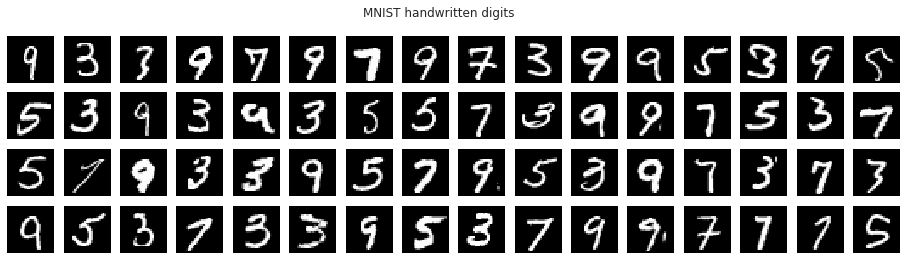

In [4]:
#plot a few MNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

### Building the model
When defining the model the latent layer must act as a bottleneck of information, so that we ensure that we find a strong internal representation. We initialize the VAE with 1 hidden layer in the encoder and decoder using relu units as non-linearity.

In [5]:
import torch.nn as nn
from torch.nn.functional import softplus

# define size variables
num_features = 28**2

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_features, num_samples):
        super(VariationalAutoencoder, self).__init__()
        
        self.latent_features = latent_features
        self.num_samples = num_samples

        # We encode the data onto the latent space using two linear layers
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean and variance
            nn.Linear(in_features=64, out_features=2*self.latent_features) # <- note the 2*latent_features
        )
        
        # The latent code must be decoded into the original image
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_features, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=num_features)
        )
        

    def forward(self, x): 
        outputs = {}
        
        # Split encoder outputs into a mean and variance vector
        mu, log_var = torch.chunk(self.encoder(x), 2, dim=-1)
        
        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)
                
        # Don't propagate gradients through randomness
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, self.num_samples, self.latent_features)
            
            if cuda:
                epsilon = epsilon.cuda()
        
        sigma = torch.exp(log_var/2)
        
        # We will need to unsqueeze to turn
        # (batch_size, latent_dim) -> (batch_size, 1, latent_dim)
        z = mu.unsqueeze(1) + epsilon * sigma.unsqueeze(1)        
        
        # Run through decoder
        x = self.decoder(z)
        
        # The original digits are on the scale [0, 1]
        x = torch.sigmoid(x)
        
        # Mean over samples
        x_hat = torch.mean(x, dim=1)
        
        outputs["x_hat"] = x_hat
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        
        return outputs


latent_features = 10
num_samples = 10

net = VariationalAutoencoder(latent_features, num_samples)

# Transfer model to GPU if available
if cuda:
    net = net.cuda()

print(net)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=784, bias=True)
  )
)


Following we define the PyTorch functions for training and evaluation.

In [6]:
from torch.nn.functional import binary_cross_entropy
from torch import optim

def ELBO_loss(y, t, mu, log_var):
    # Reconstruction error, log[p(x|z)]
    # Sum over features
    likelihood = -binary_cross_entropy(y, t, reduction="none")
    likelihood = likelihood.view(likelihood.size(0), -1).sum(1)

    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch
    ELBO = torch.mean(likelihood) - torch.mean(kl)
    
    # notice minus sign as we want to maximise ELBO
    return -ELBO, kl.sum()


# define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = ELBO_loss

Test the forward pass, to check that everything is in order.

In [7]:
from torch.autograd import Variable

x, _ = next(iter(train_loader))
x = Variable(x)

if cuda:
    x = x.cuda()

outputs = net(x)

x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
z = outputs["z"]

loss, kl = loss_function(x_hat, x, mu, log_var)

print(x.shape)
print(x_hat.shape)
print(z.shape)
print(loss)
print(kl)

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 10, 10])
tensor(543.9775, grad_fn=<NegBackward>)
tensor(2.4279, grad_fn=<SumBackward0>)


In the training loop we sample each batch and evaluate the error, latent space, and reconstructions on every epoch.

**NOTE** this will take a while on CPU.

In [8]:
wandb.watch(net)

In [10]:
def train(args, model, device, train_loader, optimizer, epoch):
    # Switch model to training mode. This is necessary for layers like dropout, batchnorm etc which behave differently in training and evaluation mode
    model.train()
    
    # We loop over the data iterator, and feed the inputs to the network and adjust the weights.
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx > 20:
          break
        # Load the input features and labels from the training dataset
        data, target = data.to(device), target.to(device)
        
        # Reset the gradients to 0 for all learnable weight parameters
        optimizer.zero_grad()
        
        # Forward pass: Pass image data from training dataset, make predictions about class image belongs to (0-9 in this case)
        output = model(data)
        
        # Define our loss function, and compute the loss
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']

        elbo, kl = loss_function(x_hat, x, mu, log_var)        
        # Backward pass: compute the gradients of the loss w.r.t. the model's parameters
        elbo.backward()
        
        # Update the neural network weights
        optimizer.step()
        
        wandb.log({
        "Test elbo": elbo.item(),
        "Test KL": kl.item()
        })

In [11]:
def test(args, model, device, test_loader, classes):
    # Switch model to evaluation mode. This is necessary for layers like dropout, batchnorm etc which behave differently in training and evaluation mode
    model.eval()
    test_loss = 0
    correct = 0

    example_images = []
    with torch.no_grad():
        data, target = next(iter(test_loader))
        # Load the input features and labels from the test dataset
        data, target = data.to(device), target.to(device)

        # Make predictions: Pass image data from test dataset, make predictions about class image belongs to (0-9 in this case)
        output = model(data)

        # Compute the loss sum up batch loss
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        z = outputs["z"]

        elbo, kl = loss_function(x_hat, x, mu, log_var)

        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()
        
        #visualize latent space
        rows = 8
        columns = batch_size // rows
        plt.title('Latent space')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')

        span = np.linspace(-4, 4, rows)
        grid = np.dstack(np.meshgrid(span, span)).reshape(-1, 2)

        # If you want to use a dimensionality reduction method you can use
        # for example PCA by projecting on two principal dimensions
        z = PCA(n_components=2).fit_transform(np.mean(z, axis=1))

        colors = iter(plt.get_cmap('Set1')(np.linspace(0, 1.0, len(classes))))
        for c in classes:
            plt.scatter(*z[c == y.numpy()].reshape(-1, 2).T, c=next(colors), marker='o', label=c)

        if show_sampling_points:
            plt.scatter(*grid.T, color="k", marker="x", alpha=0.5, label="Sampling points")




    # WandB – wandb.log(a_dict) logs the keys and values of the dictionary passed in and associates the values with a step.
    # You can log anything by passing it to wandb.log, including histograms, custom matplotlib objects, images, video, text, tables, html, pointclouds and other 3D objects.
    # Here we use it to log test accuracy, loss and some test images (along with their true and predicted labels).
    wandb.log({
        "Latent Space": plt,
        "Test elbo": elbo.item(),
        "Test KL": kl.item()
        })

In [ ]:
# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config          # Initialize config
config.batch_size = 4          # input batch size for training (default: 64)
config.test_batch_size = 10    # input batch size for testing (default: 1000)
config.epochs = 50             # number of epochs to train (default: 10)
config.lr = 0.1               # learning rate (default: 0.01)
config.momentum = 0.1          # SGD momentum (default: 0.5) 
config.no_cuda = False         # disables CUDA training
config.seed = 42               # random seed (default: 42)
config.log_interval = 10     # how many batches to wait before logging training status

In [ ]:
   for epoch in range(1, config. + 1):
        train(config, model, device, train_loader, optimizer, epoch)
        test(config, model, device, test_loader, classes)
        
    # WandB – Save the model checkpoint. This automatically saves a file to the cloud and associates it with the current run.
    torch.save(model.state_dict(), "model.h5")
    wandb.save('model.h5')